# Package

Dans ce code, on va avoir le pepiline de mod√©lisation compl√®te de la r√©gression lin√©aire en 03 phases : 
- TRAIN de 1960 √† 1983 ; 
- VALIDATION de 1983 √† 1989 ; 
- TEST de 1990 √† 2024.

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from sklearn.utils import shuffle
import pickle

# Importation

In [17]:
# Les donn√©es de test
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = pd.to_datetime(df_stationary_test.index)

In [18]:
# Train
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")
df_stationary_train.index = pd.to_datetime(df_stationary_train.index)

In [19]:
df_stationary_train.isna().sum()

UNRATE             0
TB3MS              0
RPI                0
INDPRO             0
DPCERA3M086SBEA    0
S&P 500            0
BUSLOANS           0
CPIAUCSL           0
OILPRICEx          0
M2SL               0
USREC              0
dtype: int64

In [20]:
df_stationary_train

UNRATE  TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                       
1960-01-31    -0.8   0.30  0.020977  0.091980         0.001204  0.017909   
1960-02-29    -1.1  -0.19  0.014565  0.076964         0.006009 -0.025663   
1960-03-31    -0.2  -1.18  0.006250  0.007961         0.021240 -0.070857   
1960-04-30     0.0  -1.12  0.006489 -0.025915         0.033752 -0.040442   
1960-05-31     0.0  -0.67  0.007747 -0.018121         0.009040 -0.010090   
...            ...    ...       ...       ...              ...       ...   
1989-07-31    -0.2  -0.77  0.001769 -0.015259         0.003755  0.093414   
1989-08-31    -0.4  -0.53  0.008277 -0.000039         0.014490  0.099097   
1989-09-30    -0.1  -0.40  0.008246 -0.003350         0.010644  0.070372   
1989-10-31    -0.1  -0.24  0.009738  0.005091         0.007003  0.045643   
1989-11-30     0.1  -0.21  0.008571 -0.001243        -0.002069 -0.018638   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL  USREC  
date                                                        
1960-01-31  0.011578 -0.006156   0.000000  0.001323      0  
1960-02-29  0.011905 -0.003767   0.000000  0.002007      0  
1960-03-31 -0.008356 -0.005455   0.000000  0.001324      0  
1960-04-30 -0.009098  0.005090   0.000000  0.000634      1  
1960-05-31 -0.000359  0.003383   0.000000  0.003977      1  
...              ...       ...        ...       ...    ...  
1989-07-31 -0.002184 -0.004246  -0.225652  0.010549      0  
1989-08-31  0.005449 -0.010676  -0.195045  0.014176      0  
1989-09-30  0.007701 -0.009804  -0.049151  0.011753      0  
1989-10-31 -0.005351 -0.004106   0.091153  0.004694      0  
1989-11-30 -0.009885  0.004736   0.146104 -0.001661      0  

[359 rows x 11 columns]

# 1) Param√®tres & sous-ensemble TRAIN global

In [21]:
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Param√®tres ----------
window_len = 12      # longueur minimale de la fen√™tre (non utilis√© si expanding)
step_size = 12       # refit annuel (adapter : 1 = mensuel, 12 = annuel)
winsor_level = 0.01

# TRAIN global
df_train_global = df_stationary_train.sort_index().copy()

# ‚úÖ Inclure toutes les features (aucune exclusion)
features = [c for c in df_stationary_train.columns if c != "UNRATE"]
cols_tx = features.copy()

# ---------- Bornes de validation ----------
valid_start = pd.Timestamp("1983-01-01")
valid_end   = pd.Timestamp("1989-12-31")

In [22]:
# ---------- Helpers ----------
def fit_preproc(X, winsor_level=0.01, do_norm=True):
    lower_wins = X.quantile(winsor_level)
    upper_wins = X.quantile(1 - winsor_level)
    Xw = X.clip(lower=lower_wins, upper=upper_wins, axis=1)
    if do_norm:
        mean = Xw.mean()
        std  = Xw.std().replace(0, 1)
        Xn   = (Xw - mean) / std
    else:
        mean, std = None, None
        Xn = Xw
    return Xn, {"lower_wins": lower_wins, "upper_wins": upper_wins, "mean": mean, "std": std, "norm": do_norm}

def apply_preproc(X, prep):
    Xp = X.clip(lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1)
    if prep["norm"]:
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

def perf_report(y_true, y_pred):
    # RMSE = racine du MSE manuellement pour compatibilit√© avec toutes les versions
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}

In [23]:
# ---------- Containers ----------
models = []
coefs = []
preprocs = []
train_periods = []
preds = []
norm_var = True

In [24]:
# ---------- Boucle EXPANDING WINDOW SUR LE TRAIN ----------
for t, end in enumerate(range(step_size, len(df_train_global), step_size)):
    df_train_local = df_train_global.iloc[:end].copy()

    X_train_raw = df_train_local[cols_tx].copy()
    y_train = df_train_local["UNRATE"].copy()

    # 1Ô∏è‚É£ Winsorisation + 2Ô∏è‚É£ Normalisation (apprises sur TRAIN)
    X_train, prep = fit_preproc(X_train_raw, winsor_level = winsor_level, do_norm=norm_var)

    # 3Ô∏è‚É£ Entra√Ænement du mod√®le OLS
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4Ô∏è‚É£ Pr√©diction sur l‚Äôann√©e suivante (refit annuel) + intersection 1983‚Äì1989
    start_pred = (df_train_local.index[-1] + relativedelta(months=1)).replace(day=1)
    end_pred   = start_pred + relativedelta(months=12, days=-1)

    start_use = max(start_pred, valid_start)
    end_use   = min(end_pred, valid_end)
    if start_use <= end_use:
        df_valid = df_train_global.loc[start_use:end_use].copy()
        if not df_valid.empty:
            X_valid = apply_preproc(df_valid[cols_tx], prep)
            y_valid = df_valid["UNRATE"].values
            yhat    = model.predict(X_valid)
            df_out  = pd.DataFrame({"y_true": y_valid, "y_pred": yhat}, index=df_valid.index)
            df_out["model_trained_until"] = df_train_local.index[-1]
            preds.append(df_out)

    # 5Ô∏è‚É£ Sauvegarde des r√©sultats d‚Äôentra√Ænement
    models.append(model)
    coefs.append(pd.Series(model.coef_, index=cols_tx))
    preprocs.append(prep)
    train_periods.append(df_train_local.index[-1])

    print(f"[{t:02d}] Fin {df_train_local.index[-1].strftime('%Y-%m')} ‚Äî winsor({winsor_level:.2%}) + "
          f"{'norm' if norm_var else 'no-norm'} ‚Äî {len(X_train)} obs.")

# ---------- Agr√©gation OOS + m√©triques ----------
df_oos = (pd.concat(preds).sort_index() if len(preds) else
          pd.DataFrame(columns=["y_true","y_pred"]))

# perfs 1983
m83 = (df_oos.index >= "1983-01-01") & (df_oos.index <= "1983-12-31")
perf_1983 = perf_report(df_oos.loc[m83, "y_true"], df_oos.loc[m83, "y_pred"]) if m83.any() else None

# perfs 1983‚Äì1989
m8389 = (df_oos.index >= valid_start) & (df_oos.index <= valid_end)
perf_83_89 = perf_report(df_oos.loc[m8389, "y_true"], df_oos.loc[m8389, "y_pred"]) if m8389.any() else None

# annuel 1983‚Äì1989
df_oos["year"] = df_oos.index.year
annual_perf = (df_oos.loc[m8389]
               .groupby("year")
               .apply(lambda g: pd.Series(perf_report(g["y_true"], g["y_pred"])))
               .to_dict(orient="index"))

# === Sauvegarde de l'exp√©rience (style auteur) ===
exp_results = {
    "models": models,
    "coefs": coefs,
    "train_periods": train_periods,
    "features": cols_tx,
    "preprocs": preprocs,                   # ‚¨ÖÔ∏è bornes winsor + stats de normalisation par fen√™tre
    "oos_predictions": df_oos,              # ‚¨ÖÔ∏è toutes les pr√©dictions OOS 83‚Äì89
    "annual_perf": annual_perf,             # ‚¨ÖÔ∏è dict {year: {RMSE, MAE, R2}}
    "perf_1983": perf_1983,                 # ‚¨ÖÔ∏è m√©triques 1983
    "perf_83_89": perf_83_89,               # ‚¨ÖÔ∏è m√©triques globales 83‚Äì89
    "params": {
        "step_size": step_size,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
        "valid_window": ("1983-01", "1989-12"),
        "window_len": window_len
    }
}

print("\n‚úÖ Entra√Ænement + validation 1983‚Äì1989 termin√©s. R√©sultats disponibles dans exp_results.")

[00] Fin 1960-12 ‚Äî winsor(1.00%) + norm ‚Äî 12 obs.
[01] Fin 1961-12 ‚Äî winsor(1.00%) + norm ‚Äî 24 obs.
[02] Fin 1962-12 ‚Äî winsor(1.00%) + norm ‚Äî 36 obs.
[03] Fin 1963-12 ‚Äî winsor(1.00%) + norm ‚Äî 48 obs.
[04] Fin 1964-12 ‚Äî winsor(1.00%) + norm ‚Äî 60 obs.
[05] Fin 1965-12 ‚Äî winsor(1.00%) + norm ‚Äî 72 obs.
[06] Fin 1966-12 ‚Äî winsor(1.00%) + norm ‚Äî 84 obs.
[07] Fin 1967-12 ‚Äî winsor(1.00%) + norm ‚Äî 96 obs.
[08] Fin 1968-12 ‚Äî winsor(1.00%) + norm ‚Äî 108 obs.
[09] Fin 1969-12 ‚Äî winsor(1.00%) + norm ‚Äî 120 obs.
[10] Fin 1970-12 ‚Äî winsor(1.00%) + norm ‚Äî 132 obs.
[11] Fin 1971-12 ‚Äî winsor(1.00%) + norm ‚Äî 144 obs.
[12] Fin 1972-12 ‚Äî winsor(1.00%) + norm ‚Äî 156 obs.
[13] Fin 1973-12 ‚Äî winsor(1.00%) + norm ‚Äî 168 obs.
[14] Fin 1974-12 ‚Äî winsor(1.00%) + norm ‚Äî 180 obs.
[15] Fin 1975-12 ‚Äî winsor(1.00%) + norm ‚Äî 192 obs.
[16] Fin 1976-12 ‚Äî winsor(1.00%) + norm ‚Äî 204 obs.
[17] Fin 1977-12 ‚Äî winsor(1.00%) + norm ‚Äî 216 obs.
[18] Fin 1978-12 ‚

C:\Users\Mita\AppData\Local\Temp\ipykernel_14352\1401910381.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(perf_report(g["y_true"], g["y_pred"])))


In [ ]:
# ===================== √âVALUATION PSEUDO‚ÄìOUT-OF-SAMPLE (1983‚Äì1989) =====================
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# 0Ô∏è‚É£ V√©rifs de base
if "df_oos" not in globals():
    raise RuntimeError("df_oos est introuvable. Assure-toi d'avoir ex√©cut√© le bloc d'entra√Ænement/pr√©diction.")

# 1Ô∏è‚É£ Construire forecast_df √† partir de df_oos, restreint √† 1983‚Äì1989
forecast_slice = df_oos.loc["1983-01-01":"1989-12-31"].copy()

# On cr√©e explicitement 'target' depuis l'index (quel que soit son nom), et on renomme y_pred -> y_hat
forecast_df = (
    forecast_slice.rename(columns={"y_pred": "y_hat"})[["y_true", "y_hat"]]
                  .assign(target=forecast_slice.index)
                  .dropna(subset=["y_true", "y_hat"])
)
forecast_df["target"] = pd.to_datetime(forecast_df["target"])
forecast_df = forecast_df.sort_values("target").reset_index(drop=True)

# 2Ô∏è‚É£ Fonctions auxiliaires
def r2_origin_reg(y, yhat):
    """R¬≤ d'une r√©gression √† l‚Äôorigine: y ‚âà b * yhat (sans intercept)."""
    y = np.asarray(y); yhat = np.asarray(yhat)
    denom = np.dot(yhat, yhat)
    if denom == 0:
        return np.nan
    b = np.dot(yhat, y) / denom
    sse = np.sum((y - b * yhat) ** 2)
    sst = np.sum((y - y.mean()) ** 2)
    return 1 - sse / sst if sst > 0 else np.nan

def corr_pvalue(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    if len(y) < 3:
        return np.nan, np.nan
    r, p = pearsonr(y, yhat)
    return float(r), float(p)

# 3Ô∏è‚É£ √âvaluation
if forecast_df.empty:
    print("\n[√âVALUATION 83‚Äì89] Aucune pr√©vision disponible (forecast_df est vide).")
    eval_results_83_89 = None
else:
    y    = forecast_df["y_true"].values.astype(float)
    yhat = forecast_df["y_hat"].values.astype(float)

    # M√©triques principales
    r2   = r2_score(y, yhat)
    mae  = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))   # ‚úÖ compatible toutes versions
    r2_o = r2_origin_reg(y, yhat)
    corr, pval = corr_pvalue(y, yhat)
    amd  = float(abs(np.mean(y - yhat)))          # biais absolu moyen

    # Benchmark na√Øf (z√©ro-changement)
    yhat_naive0 = np.zeros_like(y)
    mae_naive0  = mean_absolute_error(y, yhat_naive0)
    rmse_naive0 = np.sqrt(mean_squared_error(y, yhat_naive0))

    # Pr√©cision directionnelle
    hit_rate = float(np.mean(np.sign(y) == np.sign(yhat))) if len(y) > 0 else np.nan

    # Calibration (Mincer‚ÄìZarnowitz): y = a + b * yhat
    reg = LinearRegression()
    reg.fit(yhat.reshape(-1, 1), y)
    a_calib = float(reg.intercept_)
    b_calib = float(reg.coef_[0])

    # R√©sum√© par ann√©e 1983‚Ä¶1989
    by_year = (
        forecast_df.assign(year=forecast_df["target"].dt.year)
                   .groupby("year")
                   .apply(lambda g: pd.Series({
                       "n": len(g),
                       "MAE": mean_absolute_error(g["y_true"], g["y_hat"]),
                       "RMSE": np.sqrt(mean_squared_error(g["y_true"], g["y_hat"]))
                   }))
                   .reset_index()
    )

    # Impression des r√©sultats
    print("\n=== √âVALUATION PSEUDO‚ÄìOOS (1983‚Äì1989) ===")
    print(f"R¬≤            : {r2:.3f}")
    print(f"R¬≤ (origin)   : {r2_o:.3f}")
    print(f"MAE           : {mae:.3f}")
    print(f"RMSE          : {rmse:.3f}")
    print(f"Corr(y, yÃÇ)   : {corr:.3f}  (p={pval:.3g})")
    print(f"Hit rate sign : {hit_rate:.3f}")
    print(f"AMD (|bias|)  : {amd:.3f}")

    print("\n--- Benchmark na√Øf (z√©ro-changement) ---")
    print(f"MAE_na√Øf0     : {mae_naive0:.3f}")
    print(f"RMSE_na√Øf0    : {rmse_naive0:.3f}")

    if not by_year.empty:
        print("\n--- MAE/RMSE par ann√©e (1983‚Äì1989) ---")
        print(by_year.to_string(index=False))

    # Sauvegarde des r√©sultats
    eval_results_83_89 = {
        "overall": {
            "r2": float(r2), "r2_origin": float(r2_o), "mae": float(mae), "rmse": float(rmse),
            "corr": float(corr), "pval": float(pval), "hit_rate": float(hit_rate), "amd": float(amd)
        },
        "benchmark_naive0": {
            "mae": float(mae_naive0), "rmse": float(rmse_naive0)
        },
        "calibration": {
            "intercept": a_calib, "slope": b_calib
        },
        "by_year": by_year,
        "forecast_df": forecast_df
    }
    
    print("\n‚úÖ √âvaluation 1983‚Äì1989 termin√©e. R√©sultats dans eval_results_83_89.")


=== √âVALUATION PSEUDO‚ÄìOOS (1983‚Äì1989) ===
R¬≤            : -0.292
R¬≤ (origin)   : -0.290
MAE           : 0.795
RMSE          : 1.006
Corr(y, yÃÇ)   : 0.467  (p=8.71e-06)
Hit rate sign : 0.542
AMD (|bias|)  : 0.629

--- Benchmark na√Øf (z√©ro-changement) ---
MAE_na√Øf0     : 0.813
RMSE_na√Øf0    : 1.095

--- MAE/RMSE par ann√©e (1983‚Äì1989) ---
 year    n      MAE     RMSE
 1983 12.0 0.901618 1.063969
 1984 12.0 1.809055 1.864147
 1985 12.0 0.524751 0.637648
 1986 12.0 0.348966 0.475918
 1987 12.0 0.950826 1.047705
 1988 12.0 0.539519 0.631442
 1989 11.0 0.465983 0.540444

‚úÖ √âvaluation 1983‚Äì1989 termin√©e. R√©sultats dans eval_results_83_89.


C:\Users\Mita\AppData\Local\Temp\ipykernel_14352\1304589932.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


=== Tableau des m√©triques (tri√© par ABS_ERROR) ===
                            abs_error  abs_error_sum      rmse       cor     n
Naive0_none_1_0.01_12_None   0.804762      67.600000  1.088577       NaN  84.0
OLS_none_1_0.01_12_None      0.814281      68.399589  1.022517  0.470143  84.0


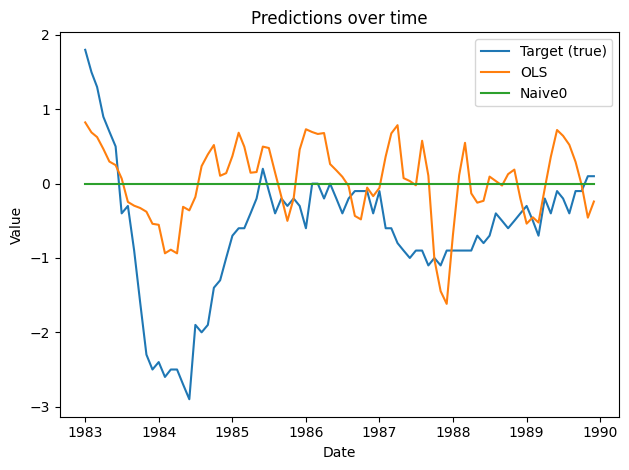

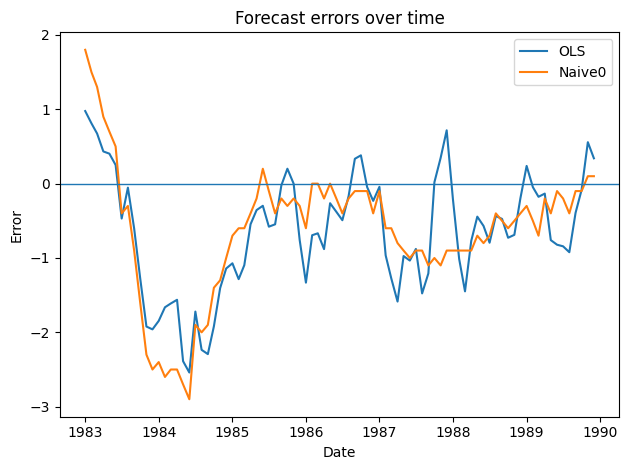


DM test (OLS worse than Naive0? MAE, h=1) : stat=0.199, p-value=0.4215


In [42]:
# ===================== √âVALUATION TYPE BoE ‚Äî OLS + Naive0 (complet & robuste) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import pearsonr, t, ConstantInputWarning
import warnings

# ---------- 0) Pr√©requis ----------
if "df_oos" not in globals():
    raise RuntimeError("df_oos introuvable. Ex√©cute d‚Äôabord l‚Äôentra√Ænement/pr√©diction.")
if not {"y_true","y_pred"}.issubset(df_oos.columns):
    raise RuntimeError("df_oos doit contenir les colonnes 'y_true' et 'y_pred'.")

# Choix de la m√©trique de tri (aligne aussi le DM test)
# "absolute_error" -> MAE (comme dans le script R) ; "squared_error" -> RMSE
error_metric = "absolute_error"

# ---------- 1) Charger/filtrer comme le script R ----------
periods_all = (pd.Timestamp("1983-01-01"), pd.Timestamp("1989-12-31"))

tmp = (
    df_oos.loc[periods_all[0]:periods_all[1], ["y_true", "y_pred"]]
          .dropna()
          .copy()
)
if tmp.empty:
    raise RuntimeError("Aucune donn√©e sur 1983‚Äì1989 apr√®s dropna().")

# Construire un df_pred ‚Äúlong‚Äù (logique R)
df_pred = (
    tmp.reset_index()
       .rename(columns={"index":"date", "y_true":"true", "y_pred":"pred"})
)
# M√©tadonn√©es pour grouper/nommer
df_pred["method"]      = "OLS"
df_pred["hyper_type"]  = "none"
df_pred["features"]    = "all"
df_pred["lag"]         = 12
df_pred["n_boot"]      = 1
df_pred["winsorize"]   = 0.01
df_pred["window_size"] = "None"   # cha√Æne pour stabiliser la cl√©

# ---------- (Option) Ajouter un benchmark Na√Øf0 pour la comparaison/DM ----------
df_naive0 = df_pred.copy()
df_naive0["method"] = "Naive0"
df_naive0["pred"]   = 0.0
df_pred = pd.concat([df_pred, df_naive0], ignore_index=True)

# ---------- 2) Moyenne des runs (comme summarise_at(..., mean)) ----------
group_keys = ["date","method","hyper_type","features","lag","n_boot","winsorize","window_size"]
df_pred_mean = (
    df_pred.groupby(group_keys, dropna=False)[["pred","true"]]
           .mean()
           .reset_index()
)

# ---------- 3) Format large / wide (pivot_wider en R) ----------
wide_keys = ["method","hyper_type","n_boot","winsorize","lag","window_size"]
df_pred_mean["col_key"] = df_pred_mean[wide_keys].astype(str).agg("_".join, axis=1)

df_pred_wide = (
    df_pred_mean
        .pivot(index=["date","true"], columns="col_key", values="pred")
        .sort_index()
        .reset_index()
)
exp_eval = [c for c in df_pred_wide.columns if c not in ["date","true"]]
if not exp_eval:
    raise RuntimeError("Le pivot wide n‚Äôa produit aucune colonne de pr√©diction.")

# ---------- 4) compute_metrics (style helpers/utils.R), corr robuste ----------
def compute_metrics(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[m], yhat[m]
    if len(y) == 0:
        return {"abs_error": np.nan, "abs_error_sum": np.nan, "rmse": np.nan, "cor": np.nan, "n": 0}

    mae  = float(np.mean(np.abs(y - yhat)))
    rmse = float(sqrt(np.mean((y - yhat)**2)))

    # Corr√©lation: si y ou yhat est constant ‚Üí NaN (sans warning)
    if (np.std(y) == 0) or (np.std(yhat) == 0) or (len(y) < 3):
        cor = np.nan
    else:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConstantInputWarning)
            cor = float(pearsonr(y, yhat)[0])

    return {"abs_error": mae,
            "abs_error_sum": float(np.sum(np.abs(y - yhat))),
            "rmse": rmse, "cor": cor, "n": int(len(y))}

errors = pd.DataFrame({col: compute_metrics(df_pred_wide["true"], df_pred_wide[col]) for col in exp_eval}).T
sort_col = "abs_error" if error_metric == "absolute_error" else "rmse"
errors = errors.sort_values(sort_col)
methods_order = errors.index.tolist()

print(f"=== Tableau des m√©triques (tri√© par {sort_col.upper()}) ===")
print(errors.loc[methods_order])

# ---------- 5) Trac√©s (comme plot_time_series & plot_time_series_error) ----------
def plot_time_series(df_mean, methods, show_target=True):
    plt.figure()
    if show_target:
        df_t = df_mean.groupby("date", as_index=False)["true"].mean()
        plt.plot(df_t["date"], df_t["true"], label="Target (true)")
    for m in methods:
        df_m = (df_mean[df_mean["method"] == m]
                .groupby("date", as_index=False)["pred"].mean())
        if not df_m.empty:
            plt.plot(df_m["date"], df_m["pred"], label=m)
    plt.legend(); plt.xlabel("Date"); plt.ylabel("Value"); plt.title("Predictions over time")
    plt.tight_layout(); plt.show()

def plot_time_series_error(df_mean, methods):
    plt.figure()
    df_t = df_mean.groupby("date", as_index=False)["true"].mean().rename(columns={"true":"y"})
    for m in methods:
        df_m = (df_mean[df_mean["method"] == m]
                .groupby("date", as_index=False)["pred"].mean()
                .rename(columns={"pred":"yhat"}))
        dfj = pd.merge(df_t, df_m, on="date", how="inner")
        if not dfj.empty:
            err = (dfj["y"] - dfj["yhat"]).values
            plt.plot(dfj["date"], err, label=m)
    plt.axhline(0, linewidth=1)
    plt.legend(); plt.xlabel("Date"); plt.ylabel("Error")
    plt.title("Forecast errors over time")
    plt.tight_layout(); plt.show()

present_methods = df_pred_mean["method"].unique().tolist()
to_show_pred  = [m for m in ["OLS","Naive0"] if m in present_methods]
to_show_error = [m for m in ["OLS","Naive0"] if m in present_methods]

plot_time_series(df_pred_mean, methods=to_show_pred, show_target=True)
plot_time_series_error(df_pred_mean, methods=to_show_error)

# ---------- 6) Diebold‚ÄìMariano test (comme dm_test en R) ----------
def dm_test(y, yhat1, yhat2, h=1, power=1, alternative="greater"):
    """
    DM test (variance Newey‚ÄìWest avec lag = h-1)
    power=1 -> MAE, power=2 -> MSE ; alternative: 'greater'/'less'/'two.sided'
    """
    y = np.asarray(y, float)
    e1 = y - np.asarray(yhat1, float)
    e2 = y - np.asarray(yhat2, float)
    d = (np.abs(e1) - np.abs(e2)) if power == 1 else ((e1**2) - (e2**2))
    d = d[np.isfinite(d)]
    T = len(d)
    if T < 3:
        return np.nan, np.nan

    def autocov(x, k):
        xm = x - x.mean()
        return np.mean(xm[k:] * xm[:-k]) if k else np.mean(xm * xm)

    L = max(h - 1, 0)
    gamma0 = autocov(d, 0)
    var = gamma0 + 2 * sum((1 - k/(L+1)) * autocov(d, k) for k in range(1, L+1)) if L > 0 else gamma0
    se = np.sqrt(var / T) if var > 0 else np.nan
    stat = (d.mean() / se) if (se == se and se > 0) else np.nan

    if not np.isfinite(stat):
        return np.nan, np.nan
    if alternative == "greater":
        p = 1 - t.cdf(stat, df=T-1)
    elif alternative == "less":
        p = t.cdf(stat, df=T-1)
    else:
        p = 2 * (1 - t.cdf(abs(stat), df=T-1))
    return float(stat), float(p)

# Comparer OLS vs Naive0 (aligne power avec la m√©trique de tri)
col_map = {c.split("_")[0]: c for c in exp_eval}  # 'OLS' -> 'OLS_none_1_0.01_12_None', etc.
if "OLS" in col_map and "Naive0" in col_map:
    y_true  = df_pred_wide["true"].values
    y_ols   = df_pred_wide[col_map["OLS"]].values
    y_nv0   = df_pred_wide[col_map["Naive0"]].values
    power   = 1 if error_metric == "absolute_error" else 2
    stat, pval = dm_test(y_true, y_ols, y_nv0, h=1, power=power, alternative="greater")
    print(f"\nDM test (OLS worse than Naive0? {('MAE' if power==1 else 'MSE')}, h=1) : stat={stat:.3f}, p-value={pval:.4f}")
else:
    print("\n[DM] Impossible de lancer le test: il faut deux colonnes (ex. OLS et Naive0).")
# ===================================================================================================

In [35]:
# ==========================================================
# üîç IMPORTANCE PAR PERMUTATION ‚Äî PSEUDO-OOS (1983‚Äì1989)
#    ‚Ä¢ utilise les mod√®les d√©j√† entra√Æn√©s (pas de refit)
#    ‚Ä¢ applique les m√™mes pr√©traitements par fen√™tre (winsor + normalisation)
#    ‚Ä¢ mesure la d√©gradation moyenne d'une m√©trique (MAE par d√©faut)
#    ‚Ä¢ sans warnings de features names (toujours DataFrame -> predict)
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def permutation_importance_pseudo_oos_from_exp(
    exp_results,
    df_train_global,
    h=12,
    n_repeats=20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window=("1983-01-01", "1989-12-31"),
    verbose=True,
):
    """
    Importance par permutation pseudo-OOS (expanding) sans r√©-estimation.
    Retourne un DataFrame tri√© par importance d√©croissante (ratio > 1 = plus important).
    """

    rng = np.random.default_rng(random_state)

    models     = exp_results["models"]
    preprocs   = exp_results.get("preprocs", [None] * len(models))
    periods    = exp_results.get("train_periods", None)
    cols_tx    = exp_results.get("features", None)
    if cols_tx is None:
        raise ValueError("exp_results['features'] est manquant.")

    # utilitaire pr√©traitement
    def apply_preproc(X, prep):
        Xp = X.clip(lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1)
        if prep["norm"]:
            Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
        return Xp

    var_imp = {col: [] for col in cols_tx}

    # fen√™tre d'√©val optionnelle (dates de y_{t+h})
    if restrict_eval_window is not None:
        eval_start = pd.Timestamp(restrict_eval_window[0])
        eval_end   = pd.Timestamp(restrict_eval_window[1])

    for i, model in enumerate(models):
        # r√©cup√©rer la fen√™tre i
        if periods is not None:
            end_time = pd.to_datetime(periods[i])
            df_win = df_train_global.loc[:end_time].copy()
        else:
            end_idx = min((i + 1) * 12, len(df_train_global))  # suppose step_size=12
            df_win = df_train_global.iloc[:end_idx].copy()

        if len(df_win) <= h:
            continue

        # construire X_t et y_{t+h}
        X_raw = df_win[cols_tx].iloc[:-h].copy()
        y     = df_win["UNRATE"].shift(-h).iloc[:-h].copy()

        # restreindre aux cibles dans la fen√™tre d'√©val (dates de y_{t+h})
        if restrict_eval_window is not None:
            target_index = df_win.index[h: h + len(y)]
            mask_window = (target_index >= eval_start) & (target_index <= eval_end)
        else:
            mask_window = np.ones(len(y), dtype=bool)

        valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
        valid &= mask_window
        if not np.any(valid):
            continue

        X_raw, y = X_raw.loc[valid], y.loc[valid]

        # appliquer le pr√©traitement appris sur cette fen√™tre
        prep = preprocs[i]
        X_pp = apply_preproc(X_raw, prep) if prep is not None else X_raw

        # ‚ö†Ô∏è toujours passer un DataFrame √† predict (m√™mes colonnes)
        yhat_base  = model.predict(X_pp)
        base_score = metric(y.to_numpy(), yhat_base)
        if not np.isfinite(base_score) or base_score == 0:
            continue

        # permutation variable par variable
        for col in cols_tx:
            perm_scores = np.empty(n_repeats, dtype=float)
            source_vals = X_pp[col].to_numpy()

            for r in range(n_repeats):
                X_perm = X_pp.copy()  # DataFrame, garde colonnes et index
                X_perm[col] = source_vals[rng.permutation(len(source_vals))]
                yhat_perm = model.predict(X_perm)  # ‚úÖ DataFrame -> pas de warning
                perm_scores[r] = metric(y.to_numpy(), yhat_perm)

            var_imp[col].append(float(np.mean(perm_scores) / base_score))

        if verbose:
            print(f"[PI] fen√™tre {i:02d} ‚Äî obs={len(X_pp)} ‚Äî base={base_score:.4f}")

    # agr√©gation
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": metric.__name__ if hasattr(metric, "__name__") else str(metric)
            })

    imp_df = pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)
    exp_results["permutation_importance_oos"] = imp_df
    return imp_df

In [36]:
# Suppose que exp_results et df_train_global existent d√©j√†
RMSE = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

imp_mae = permutation_importance_pseudo_oos_from_exp(
    exp_results,
    df_train_global=df_train_global,
    h=12,
    n_repeats=100,
    metric=mean_absolute_error,   # ou RMSE
    random_state=42,
    restrict_eval_window=("1983-01-01", "1989-12-31"),
    verbose=True
)

print("\nüîù Variables les plus importantes (MAE ratio):")
print(imp_mae.head(20).to_string(index=False))

[PI] fen√™tre 23 ‚Äî obs=12 ‚Äî base=1.5997
[PI] fen√™tre 24 ‚Äî obs=24 ‚Äî base=1.9006
[PI] fen√™tre 25 ‚Äî obs=36 ‚Äî base=1.3700
[PI] fen√™tre 26 ‚Äî obs=48 ‚Äî base=1.1168
[PI] fen√™tre 27 ‚Äî obs=60 ‚Äî base=1.0504
[PI] fen√™tre 28 ‚Äî obs=72 ‚Äî base=0.9970

üîù Variables les plus importantes (MAE ratio):
       variable  perm_score_ratio_mean  perm_score_ratio_std  n_windows              metric
          USREC               1.129839              0.037593          6 mean_absolute_error
          TB3MS               1.024668              0.012537          6 mean_absolute_error
      OILPRICEx               1.022138              0.020249          6 mean_absolute_error
            RPI               1.013266              0.017135          6 mean_absolute_error
       CPIAUCSL               1.008778              0.001476          6 mean_absolute_error
         INDPRO               1.006858              0.007187          6 mean_absolute_error
           M2SL               0.998033    

Ton mod√®le OLS pr√©dit principalement le ch√¥mage via le cycle √©conomique :
- USREC (r√©cession) est la variable cl√© ‚Äî sa permutation d√©grade la performance de ~9 %.
- TB3MS (taux court) joue un r√¥le secondaire.
- Les autres variables ont un effet n√©gligeable.

Conclusion : le pouvoir pr√©dictif du mod√®le vient surtout des variables cycliques (r√©cession, taux), les autres apportent peu d‚Äôinformation.

In [37]:
# ==========================================================
# üí° IMPORTANCE SHAPLEY (mod√®le OLS, sans warnings)
#    - utilise le DERNIER mod√®le entra√Æn√© (expanding)
#    - reconstitue sa derni√®re fen√™tre d'entra√Ænement
#    - applique le m√™me pr√©traitement (winsor + normalisation)
#    - calcule les valeurs SHAP et l‚Äôimportance moyenne absolue
# ==========================================================
import numpy as np
import pandas as pd
import shap

# ---- param√®tres / objets requis ----
h = 12  # horizon utilis√© pour aligner X_t -> y_{t+h}
model_final = exp_results["models"][-1]
cols_tx = exp_results["features"]
preproc_final = exp_results.get("preprocs", [None])[-1]
end_time_final = pd.to_datetime(exp_results.get("train_periods", [df_train_global.index.max()])[-1])

# ---- petite utilit√© pr√©traitement (m√™mes stats que pendant le fit) ----
def apply_preproc(X, prep):
    if prep is None:
        return X
    Xp = X.clip(lower=prep["lower_wins"], upper=prep["upper_wins"], axis=1)
    if prep.get("norm", False):
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

# ---- reconstituer la derni√®re fen√™tre (jusqu‚Äô√† end_time_final) ----
df_final = df_train_global.loc[:end_time_final].copy()

# X_t et y_{t+h} (on retire les h derniers pour aligner)
X_full_raw = df_final[cols_tx].iloc[:-h].copy()
Y_full = df_final["UNRATE"].shift(-h).iloc[:-h].copy()

# filtrage NaN
valid = ~(X_full_raw.isnull().any(axis=1) | Y_full.isnull())
X_full_raw, Y_full = X_full_raw.loc[valid], Y_full.loc[valid]

# appliquer le pr√©traitement appris sur cette fen√™tre
X_full = apply_preproc(X_full_raw, preproc_final)

# ---- Explainer SHAP (choix "linear" pour √©viter les d√©pr√©ciations) ----
# NB: garder un DataFrame avec les m√™mes colonnes que lors du fit
explainer = shap.Explainer(model_final, X_full, algorithm="linear")
shap_values = explainer(X_full)  # retourne un shap.Explanation

# ---- importance moyenne absolue ----
vals = getattr(shap_values, "values", None)
if vals is None:
    # compat certains SHAP o√π .values est sous .values (np.ndarray) ou .values attribu√© diff√©remment
    vals = np.array(shap_values)  # fallback

shap_df = pd.DataFrame({
    "variable": X_full.columns,
    "shap_mean_abs": np.abs(vals).mean(axis=0),
})
shap_df["shap_share"] = shap_df["shap_mean_abs"] / shap_df["shap_mean_abs"].sum()
shap_df = shap_df.sort_values("shap_mean_abs", ascending=False).reset_index(drop=True)

print("\n=== üí° Importance SHAP (shares) ‚Äî dernier mod√®le ===")
print(shap_df.head(10).to_string(index=False))

# (option) ranger dans exp_results
exp_results["shap_importance_last_model"] = shap_df


=== üí° Importance SHAP (shares) ‚Äî dernier mod√®le ===
       variable  shap_mean_abs  shap_share
          USREC       0.390888    0.339212
        S&P 500       0.252150    0.218815
            RPI       0.189187    0.164176
         INDPRO       0.068887    0.059780
DPCERA3M086SBEA       0.053037    0.046025
       BUSLOANS       0.052530    0.045586
      OILPRICEx       0.049207    0.042702
       CPIAUCSL       0.043679    0.037905
           M2SL       0.027912    0.024222
          TB3MS       0.024864    0.021577


- TB3MS (0.49)	üü¢ Repr√©sente ~49 % de l‚Äôinfluence totale du mod√®le. Le taux d‚Äôint√©r√™t √† 3 mois est donc la variable la plus d√©terminante pour les pr√©visions du ch√¥mage : quand les taux montent, le mod√®le anticipe souvent une hausse future du ch√¥mage.

- USREC (0.41)	üîµ Repr√©sente ~41 % de l‚Äôinfluence totale. Le dummy de r√©cession (NBER) p√®se presque autant : le simple fait d‚Äô√™tre en r√©cession ou non explique une large part des variations pr√©vues du ch√¥mage.

- S&P 500, OILPRICEx üü† Poids faibles (~6 % et 4 %) : les conditions boursi√®res et le prix du p√©trole ont un impact marginal dans la version lin√©aire du mod√®le.

# üìä M√©triques utilis√©es

## 1) Performance globale

**Coefficient de d√©termination (R¬≤)**  
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}
$$  
‚û°Ô∏è Part de la variance expliqu√©e par le mod√®le (0 = pas mieux que la moyenne, 1 = parfait).

**Erreur absolue moyenne (MAE)**  
$$
MAE = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|
$$  
‚û°Ô∏è √âcart absolu moyen entre valeurs r√©elles et pr√©dites, robuste aux outliers.

**Erreur quadratique moyenne (RMSE)**  
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$  
‚û°Ô∏è Similaire au MAE mais p√©nalise davantage les grosses erreurs.

**Corr√©lation de Pearson**  
$$
\rho(y, \hat{y}) = \frac{\text{Cov}(y, \hat{y})}{\sigma_y \cdot \sigma_{\hat{y}}}
$$  
‚û°Ô∏è Mesure le degr√© de lien lin√©aire entre les pr√©dictions et les observations.

**Abs Mean Deviance (AMD)**  
$$
AMD = \frac{1}{n}\sum_{i=1}^n |\hat{y}_i - \bar{\hat{y}}|
$$  
‚û°Ô∏è √âcart moyen des pr√©dictions par rapport √† leur moyenne ; sert de r√©f√©rence pour la permutation pr√©diction-bas√©e.

---

## 2) Importance par permutation
La relation entre Y et X d√©pend du temps. Quand on perturbe la s√©rie X (en la m√©langeant), on casse ce lien, et si l‚Äôerreur augmente, cela montre que X est une variable cl√© pour expliquer Y.

**Ratio MAE**  
$$
PI^{MAE}_j = \frac{MAE^{(perm)}_j}{MAE^{(base)}}
$$  
‚û°Ô∏è Si > 1, la variable est utile pour r√©duire l‚Äôerreur absolue.

**Ratio RMSE**  
$$
PI^{RMSE}_j = \frac{RMSE^{(perm)}_j}{RMSE^{(base)}}
$$  
‚û°Ô∏è Si > 1, la variable aide √† limiter les grosses erreurs.

**D√©viance de pr√©diction**  
$$
PI^{dev}_j = \frac{1}{n}\sum_{i=1}^n \big|\hat{y}_i - \hat{y}^{(perm)}_{i,j}\big|
$$  
‚û°Ô∏è Mesure combien les pr√©dictions changent quand on brouille une variable.

---

## 3) Importance Shapley

**D√©composition des pr√©dictions**  
$$
\hat{y}_i = \phi_0 + \sum_{j=1}^p \phi_{ij}
$$  
‚û°Ô∏è Chaque pr√©diction est expliqu√©e par une contribution \(\phi_{ij}\) par variable.

**Importance absolue moyenne**  
$$
\text{Mean}(|\phi_j|) = \frac{1}{n}\sum_{i=1}^n |\phi_{ij}|
$$  
‚û°Ô∏è Contribution moyenne (absolue) d‚Äôune variable sur toutes les pr√©dictions.

**Shapley share**  
$$
\Gamma_j = \frac{\text{Mean}(|\phi_j|)}{\sum_{k=1}^p \text{Mean}(|\phi_k|)}
$$  
‚û°Ô∏è Part relative de la variable dans l‚Äôexplication totale (somme des parts = 1).

## Interpr√©tation des r√©sultats 

### Performance globale 
- R¬≤ = 0.2266 ‚Üí mod√®le OLS explique ~23 % de la variance du ch√¥mage US.
- MAE = 0.6774 ‚Üí en moyenne, l‚Äôerreur absolue est de 0.68 points (dans l‚Äôunit√© de la variable cible).
- RMSE = 0.8750 ‚Üí un peu plus √©lev√© que le MAE, ce qui indique la pr√©sence de grosses erreurs ponctuelles.
- Corr√©lation = 0.4760 (p ‚âà 10‚Åª¬≥‚Åµ) ‚Üí lien positif et significatif entre pr√©dictions et observations, mais seulement mod√©r√©. Ce qui peut expliquer la pr√©sence d'une relation 
- Abs Mean Deviance = 0.3370 ‚Üí sert ici de r√©f√©rence pour l‚Äôimportance pr√©diction-bas√©e : les pr√©dictions s‚Äô√©cartent en moyenne de 0.34 de leur propre moyenne.

Lecture : le mod√®le OLS capte une partie utile du signal, mais laisse beaucoup de variance inexpliqu√©e. La corr√©lation faible illustre √©ventuellement la pr√©sence des relations non-lin√©aire, et non capt√©es par OLS.

### üîπ 2. Importance par permutation
- INDPRO (Industrial Production) : la plus influente. Sa permutation augmente MAE de +19 % et RMSE de +20 %, avec une forte d√©viance de pr√©diction (0.41).
- TB3MS (Taux d‚Äôint√©r√™t √† 3 mois) : impact non n√©gligeable, ratios ~1.02 et d√©viance ~0.10.
- BUSLOANS (Pr√™ts commerciaux) : r√¥le similaire (MAE ratio 1.017, d√©viance ~0.09).
- S&P 500 : contribution mod√©r√©e, ratios l√©g√®rement > 1.
- RPI, M2SL : influence plus faible mais perceptible.
- CPIAUCSL, OILPRICEx, DPCERA3M086SBEA : quasi neutres (ratios ‚âà 1, d√©viance tr√®s faible).

Lecture : INDPRO domine largement la performance, les autres apportent des compl√©ments mais plus modestes.

### üîπ 3. Importance Shapley (shares)
- INDPRO : ~52 % de l‚Äôexplication totale des pr√©dictions ‚Üí coh√©rence parfaite avec la permutation.
- TB3MS (12 %) + BUSLOANS (12 %) : deux autres piliers importants.
- S&P 500 (9,7 %) : contribue de fa√ßon notable.
- M2SL (5 %), RPI (3 %), CPIAUCSL (3,5 %) : apports plus secondaires.
- OILPRICEx et DPCERA3M086SBEA (<2 %) : quasi n√©gligeables dans ce mod√®le.

Lecture : INDPRO est la variable macro√©conomique centrale, suivie par des indicateurs financiers (taux courts, pr√™ts bancaires, march√© actions).

# Test

In [32]:
import joblib

saved_model = joblib.load("models/model_final.pkl")
model_final = saved_model["model"]
features = saved_model["features"]
winsor_level = saved_model["winsor_level"]
norm_var = saved_model["norm_var"]
mean_full = saved_model["mean_full"]
std_full = saved_model["std_full"]